# Analysis of Worked Example Data

This workbook analyzes student data

## Loading
First, we load the relevant data and supporting libraries.

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import json
from pprint import pprint
from numpy import std, mean, sqrt

def pretty_percent(a_decimal):
    return round(a_decimal*1000)/10
def used_we(events):
    if not isinstance(events, list):
        return False
    return any("worked_examples" in event for event in events)
def prior_experience(reported):
    if not isinstance(reported, list):
        return False
    return any(reported)

def isComfortable(reported):
    return "unc" not in reported

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)


In [41]:
# Anonymized Settings
# Information here should be de-anonymized before publication
FILENAME = "cs1064_worked_examples_data.json"
SECTION_MAP = {"Bart - MWF": "S18",
               "Fall 2017": "F17",
               "Panagiotis - TR": "S18-alt"}
def PRIOR_MAP(value):
    return ["Community College" if "community" in answer else
            "University" if "Virginia Tech" in answer else
            "Online" if "online" in answer else
            "High School" if "high school" in answer else
            ""
            for answer in value.split(",")]

In [42]:
with open(FILENAME, 'r') as log_data:
    data = json.load(log_data)

### Tidying

Restructure the data a little to make it easier to read with Pandas. In particular, we are going to make the data ["tidy"](https://en.wikipedia.org/wiki/Tidy_data), where each row is an observation and each column is a feature/variable.

In [43]:
tidy_data = []
for row in data:
    if not row['demographics']:
        continue
    row['user']['user_name'] = row['user'].pop('name')
    row['user']['section'] = SECTION_MAP[row['user']['section']]
    row['demographics']['Prior Computing Experience'] = PRIOR_MAP(row['demographics']['Prior Computing Experience'])
    for assignment_name, assignment in row['assignment'].items():
        assignment['name'] = assignment_name
        assignment.update(row['demographics'])
        assignment.update(row['user'])
        if row['survey']:
            assignment.update(row['survey'])
        else:
            assignment.update({'Aware?':None, 'ReadFrequency':None, 
                               'ReadWhen':None, 'ReadWhy':None, 
                               'AfterReading':None, 'ExampleWasHelpful':None})
        tidy_data.append(assignment)
df = pd.DataFrame(tidy_data)

### Filtering and Transformation

Remove certain students and problems

In [111]:
# Filter alternate section to control for instructor
df = df[df.section != "S18-alt"]
# Create column for whether they used the worked examples
df['used_we'] = df.events.apply(used_we)
df['Prior'] = df["Prior Computing Experience"].apply(prior_experience)
df['Comfort'] = df["Programming Comfort"].apply(isComfortable)
# Filtered subsection of students 
attempted = df[df.attempted]
corrected = df[df.correct]
# Spring only data
experiment = attempted[attempted.section == "S18"]

### Preview Data

In [81]:
# Pick five entries at random
df.sample(5)

,AfterReading,Aware?,Computer Comfort,ExampleWasHelpful,Gender,Prior Computing Experience,Programming Comfort,ReadFrequency,ReadWhen,ReadWhy,...,name,runs,section,time_on_task,user_id,user_name,version,used_we,Prior,Comfort
4259,"Better understood the concept being taught,Bet...",Yes,Extremely comfortable,Strongly agree,Male,[],Neither comfortable nor uncomfortable,Most of the time,"After reading the problem\, but was unsure how...",Because I was confused about how to solve the ...,...,#45.6) File Size,6,S18,274.0,1690,Vanilluxe,36,True,False,False
3796,"Better understood the concept being taught,Bet...",Yes,Extremely comfortable,Somewhat agree,Male,[High School],Slightly comfortable,Always,"After reading the problem\, but was unsure how...",Because I was confused about what the problem ...,...,#40.2) Word Frequency,3,S18,374.0,1635,Spinda,32,True,True,True
313,Better understood the concept being taught,Yes,Moderately comfortable,Somewhat agree,Male,[High School],Slightly comfortable,About half the time,"After reading the problem\, but was unsure how...",Because I was confused about how to solve the ...,...,#43.4) Multiple Returns,4,S18,211.0,1689,Bibarel,37,False,True,True
3642,None,None,Extremely comfortable,None,Male,"[Online, , ]",Slightly comfortable,None,None,None,...,#45.4) Plus or Minus,5,F17,302.0,819,Sliggoo,43,False,True,True
398,None,None,Extremely comfortable,None,Male,"[University, Online, , ]",Slightly uncomfortable,None,None,None,...,#45.5) Fix Names,4,F17,156.0,912,Braixen,29,False,True,False


## Completion Rates by Section


In [46]:
# Group by section, compute mean (with binary outcomes, that corresponds to percent)
completions = df.groupby(["section"])[['correct', 'attempted']].mean()
# Find the students who attempted but did not get it correct
completions['incomplete'] = completions['attempted'] - completions['correct']
# Find the students who never even attempted it
completions['not attempted'] = 1 - completions['attempted']
# Make the numbers into percentages and print out the table
completions[['correct', 'incomplete', 'not attempted']].apply(pretty_percent)

,correct,incomplete,not attempted
section,,,
F17,87.6,10.9,1.5
S18,83.0,12.6,4.4


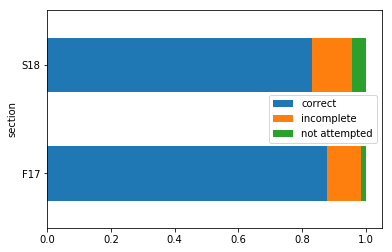

In [47]:
# Make a horizontal stacked bar chart of the interesting columns
completions[['correct', 'incomplete', 'not attempted']].plot.barh(stacked=True)
plt.show()

In [48]:
# Perform a Mann-Whitney U for each section's data
st.mannwhitneyu(df[df.section=="S18"].correct, df[df.section=="F17"].correct)

MannwhitneyuResult(statistic=2057412.0, pvalue=1.0182357659628822e-05)

From the above, we see that there was a significant but small difference in the number of completions between each semester (roughly 5%), owing largely to fewer students attempting the problems (3%).

A Mann-whitney U test was chosen instead of a T-Test because the outcome variable was dichotomous, but a Chi Square test was not used to avoid unnecessary complexity. Experimentation suggested that all three tests had the same outcome.

Subsequent analyses will filter out students who did not attempt a problem.

## Completion Rates by Problem

In [49]:
# Group sections and assignment names, find percentage rate of correctness
completions = attempted.groupby(["name", "section"]).correct.mean().apply(pretty_percent)
# Unstack the data to put 
completions.unstack()

section,F17,S18
name,,
#33.3) Cube Elements,92.1,91.1
#39.4) Default Name,92.4,86.9
#40.2) Word Frequency,88.4,76.4
#43.4) Multiple Returns,89.6,88.8
#45.3) Adding Up,96.4,95.6
#45.4) Plus or Minus,87.8,88.6
#45.5) Fix Names,85.3,85.5
#45.6) File Size,79.9,81.6


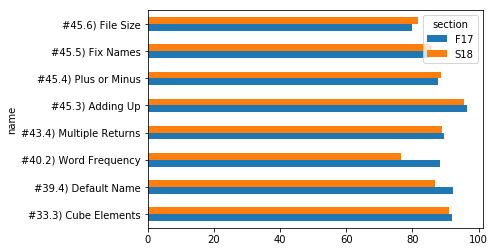

In [50]:
# Plot unstacked data as a bar chart
completions.unstack().plot.barh()
plt.show()

In [51]:
# Iterate through all the assignments
for name in sorted(attempted.name.unique()):
    # Get out the assignment's data
    assignment = attempted[attempted.name == name]
    # Perform Mann-Whitney U
    statistic, pvalue = st.mannwhitneyu(assignment[assignment.section=="S18"].correct, 
                                        assignment[assignment.section=="F17"].correct)
    print(name, pvalue<.05, statistic, pvalue, sep=", ")

#33.3) Cube Elements, False, 32224.0, 0.343459278763
#39.4) Default Name, True, 30768.0, 0.0196462743771
#40.2) Word Frequency, True, 27726.5, 0.000196173525601
#43.4) Multiple Returns, False, 29852.0, 0.382495194428
#45.3) Adding Up, False, 31551.0, 0.322763353926
#45.4) Plus or Minus, False, 31557.0, 0.393324196918
#45.5) Fix Names, False, 31735.5, 0.472194420689
#45.6) File Size, False, 31281.0, 0.320138491476


Completion rates were similar between semesters. There was significant difference only in #40.2 and #39.4, where the difference was about a little lower in the spring section.

## Time Spent by Problem

In [52]:
# Group results by assignment name and student section
time_spent = attempted.groupby(["name", "section"])
# Report mean and standard deviation of time spent
time_spent.time_on_task.agg(['mean','std']).unstack()

mean                     std            
section                         F17         S18         F17         S18
name                                                                   
#33.3) Cube Elements     366.703971  406.089362  341.893606  354.393120
#39.4) Default Name      380.996377  476.330508  379.732351  413.418886
#40.2) Word Frequency    477.341818  555.611354  335.769820  473.130580
#43.4) Multiple Returns  341.329630  335.538117  323.101395  312.741449
#45.3) Adding Up         199.315412  247.403509  167.834496  214.524501
#45.4) Plus or Minus     661.996416  740.381579  592.115531  604.382700
#45.5) Fix Names         561.401434  628.438596  534.306621  516.641391
#45.6) File Size         389.974910  477.114035  351.553944  494.880500

C:\Program Files\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


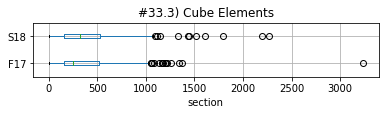

#33.3) Cube Elements, False, 1.63146362224, 0.202081896927


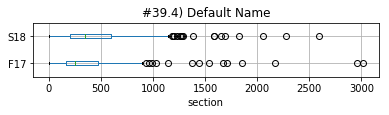

#39.4) Default Name, True, 7.38773054826, 0.00679053801055


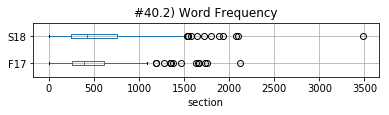

#40.2) Word Frequency, True, 4.69014726618, 0.0308062150191


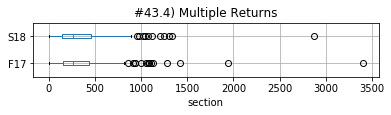

#43.4) Multiple Returns, False, 0.0403923112981, 0.840798701536


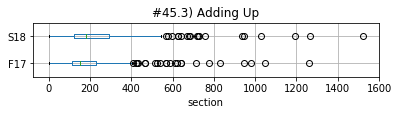

#45.3) Adding Up, True, 8.01641263709, 0.00482046732805


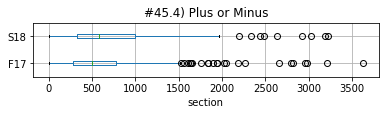

#45.4) Plus or Minus, False, 2.15818776512, 0.142434503576


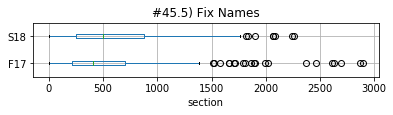

#45.5) Fix Names, False, 2.03453721896, 0.154378880649


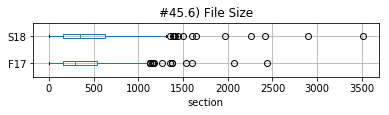

#45.6) File Size, True, 5.34858070855, 0.0211402336546


In [53]:
# For each assignment,
for name in sorted(attempted.name.unique()):
    # Get out the assignment's data
    assignment = attempted[attempted.name == name]
    # Create a horizontal box plot of time by section
    assignment.boxplot(column='time_on_task', by="section", 
                       # Keep it horizontal and adjust figure size
                       vert=False, figsize=(6,1))
    # Fix title to be assignment name
    plt.title(name)
    # remove super title that gets added by default
    plt.suptitle("")
    # Flush graph to actually make it appear
    plt.show()
    # Calculate Oneway ANOVA since we have quantitative data per section
    statistic, pvalue = st.f_oneway(assignment[assignment.section=="S18"].time_on_task, 
                                    assignment[assignment.section=="F17"].time_on_task)
    print(name, pvalue<.05, statistic, pvalue, sep=", ")

There seems to be huge variation in the time spent per problem for students (given the standard deviation). The plot appears to be normally distributed but with a long tail, indicating that there are some students who struggle longer with a problem.

In a number of problems, the spring students took significantly longer, about a minute or two longer on average.

## Worked Example Usage

In [54]:
# Group section and assignment names, find percentage rate of Worked Example usage
wes = experiment.groupby(["name", "section"]).used_we.mean().apply(pretty_percent)
# Unstack the data to put 
wes.unstack()

section,S18
name,
#33.3) Cube Elements,29.4
#39.4) Default Name,54.7
#40.2) Word Frequency,59.0
#43.4) Multiple Returns,46.2
#45.3) Adding Up,33.3
#45.4) Plus or Minus,60.1
#45.5) Fix Names,60.5
#45.6) File Size,41.2


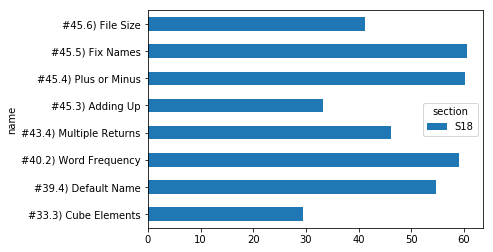

In [55]:
# Plot unstacked data as a bar chart
wes.unstack().plot.barh()
plt.show()

Worked Example usage varied heavily by problem. In no problem did all students take advantage of the WEs, and in many less than half the students took advantage of them. Given these sharp differences, it will make sense to continue analyzing each question independently.

## Demographics 

### Gender breakdown by Semester

In [56]:
(df.groupby(["section","Gender"]).size().unstack()/len(df)).apply(pretty_percent) # TODO Fix this, dividing by both sections 

Gender,Female,Male,Prefer not to say
section,,,
F17,19.0,34.7,0.2
S18,15.4,30.1,0.6


### Programming Comfort by Semester

In [57]:
# TODO Fix this, dividing by both sections 
(df.groupby(["section", "Programming Comfort"]).size().unstack()/len(df)).apply(pretty_percent)#.plot.barh()

Programming Comfort,Extremely comfortable,Extremely uncomfortable,Moderately comfortable,Moderately uncomfortable,Neither comfortable nor uncomfortable,Slightly comfortable,Slightly uncomfortable
section,,,,,,,
F17,0.4,3.3,9.2,7.7,8.8,13.8,10.7
S18,1.3,3.1,6.3,7.5,7.7,10.7,9.4


### Prior Experience By Semester 

In [67]:
df.groupby(["section", "Prior"]).user_name.unique().map(len)

section  Prior
F17      False     41
         True     240
S18      False     43
         True     197
Name: user_name, dtype: int64

### WE Awareness Data

In [ ]:
# TODO Only adds to ~92. Probably need to filter out entries w/o survey data
s18DF = df[(df.section == "S18")].dropna()
(s18DF.groupby("Aware?").size()/len(s18DF)).apply(pretty_percent)

## Survey Results

### WE Helpfulness Data

In [ ]:
# TODO Only adds to ~92. 
def helpMap(helpful):
    hmap ={"Strongly disagree": -2, "Somewhat disagree": -1, "Neither agree or disagree":0, 
     "Somewhat agree": 1, "Strongly agree": 2}
    return hmap[helpful]
helpful=(s18DF.groupby("ExampleWasHelpful").size()/len(s18DF)).apply(pretty_percent)

helpful#.plot.barh()


### Reported Usage

In [ ]:
(s18DF.groupby("ReadFrequency").size()/len(s18DF)).apply(pretty_percent)

### WE Use X Prior Experience vs TOT, Completion, runs

In [108]:
pa = attempted.drop_duplicates("user_name").groupby(["section", "Comfort", "used_we"])
pa.size()

section  Comfort  used_we
F17      False    False      159
         True     False      122
S18      False    False       97
                  True        47
         True     False       72
                  True        24
dtype: int64

In [130]:
probs = ["#39.4) Default Name", "#43.4) Multiple Returns", "#45.5) Fix Names", "#45.6) File Size"]
filtered = corrected[(corrected.name.isin(probs)) & (corrected.section=="S18")]
filtered.groupby(["used_we",  "Comfort","section"]).time_on_task.agg(["mean", "std"])
st.mannwhitneyu(filtered[filtered.used_we & filtered.Comfort].time_on_task,
                filtered[filtered.used_we & ~filtered.Comfort].time_on_task) 
cohen_d(filtered[filtered.used_we & filtered.Comfort].time_on_task,
                filtered[filtered.used_we & ~filtered.Comfort].time_on_task)
# There was a significant difference between students who used the worked examples and had 
#prior experience vs. those who haad no prior experence,
#with a medium negative effect size

-0.30311433240682695

## More questions

What was the difference in [Percentage Correct, Time Spent] of students who used Worked Examples, by problem?

What was the percentage of students who had prior experience?

What was the difference in [Percentage Correct, Time Spent] of students who had prior experience, by problem?

What was the cross tabulated percentage of students who had (prior experience) x (used worked examples)?

What was the difference in [Percentage Correct, Time Spent] of students by gender, by problem?

What was the cross tabulated percentage of students who had (gender) x (used worked examples)?

